In [1]:
from utils import load_data

import numpy as np
import numpy as np
import torch
from tqdm import tqdm

import faiss
from sklearn.metrics import pairwise_distances_argmin_min
import torch.nn.functional as F
from scipy.special import softmax

from sklearn.covariance import EmpiricalCovariance
from numpy.linalg import norm, pinv
from scipy.special import logsumexp



import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from plots import plot
from scores import score
from utils import get_network_weights, load_data, _ECELoss

from pyodscores import score as py_score
# Directory of features/logits etc.
#data_dir ="/home/tarkus/Desktop/WILDS/paper_2022/surprised_classifiers/surprised_classifiers/data_unnormalized/"
# Path to Folder with features
data_dir ="/home/tarkus/Desktop/WILDS/paper_2022/train_classifiers/DomainBed/features"

# Directory of Model weights
model_dir = data_dir

In [2]:
def myHash(text:str):
    ahash=1
    for ch in text:
        ahash = ( ahash*281  ^ ord(ch)*997) & 0xFFFFFFFF
    return ahash

In [3]:
from metrics import compute_metric
import time

import pickle
results =  {}
results_scores = {}
with open('results_hyp.pickle', 'rb') as handle:
    results = pickle.load(handle)
with open('results_scores_hyp.pickle', 'rb') as handle:
    results_scores = pickle.load(handle)
print('keys' ,  results.keys())

metrics = ['intersection_fraction_test','ece_ood_test', 'ece_iid_test', 'ausc_ece_alpha_shifted', 'ausc_ece_alpha', 'acc_test', 'acc_val', 'intersection_fraction', 'intersection_fraction_denoised','dot_product','dot_product_corrected', "dot_product_corrected_05" ,'ausc_alpha_normalized', 'ausc_alpha_shifted', 'ausc_alpha', 'ausc_fracs', 'ausc_fracs_shifted']

datasets = ['OfficeHome', 'PACS',  'TerraIncognita', 'VLCS', 'DomainNet']#, 'DomainNet']#, 'SVIRO']#, 'PACS', 'TerraIncognita', 'SVIRO']#, 'VLCS','PACS',  "TerraIncognita"]

configs = [
    {'score_fct': 'knn', 'K':1},
    #{'score_fct': 'knn', 'K':2},
    #{'score_fct': 'knn', 'K':5},
    #{'score_fct': 'knn', 'K':50},
    {'score_fct': 'max_softmax'},
    {'score_fct': 'max_logit'} ,
    #{'score_fct': 'HBOS'} ,
    {'score_fct': 'GMM', 'n_components': 1, 'iterations':100, 'covariance_type':'full' } ,
    #{'score_fct': 'GMM', 'n_components': 1, 'iterations':100, 'covariance_type':'diag' } ,
    #{'score_fct': 'GMM', 'n_components': 6, 'iterations':250, 'covariance_type':'full' } ,
    #{'score_fct': 'vim'} ,
    #{'score_fct': 'mahalanobis'},
    #{'score_fct': 'LODA'}
    #{'score_fct': 'PCA'}
] 

percentages = [0, 0.05, 0.1, 0.15, 0.2, 0.25]


ENVS_DIC = {'OfficeHome':4, 'VLCS':4, 'PACS': 4, 'TerraIncognita': 4, 'SVIRO':10, 'DomainNet': 6}
algorithms =  ['ERM', 'SD', "Mixup", 'VREx', 'SagNet', 'Clip_Nonlinear']#, 'ViT']

keys dict_keys([355810351, 3933108993, 3929589533, 678710382, 1711934266, 1300242229, 1418915825, 2893531402, 3672618445, 3930499830, 413817421, 3295367327])


In [4]:
import seaborn as sns
import pandas as pd
%matplotlib inline


metric ='ausc_alpha_shifted'
d = {}

d['score_function'] = []
d['dataset'] = []
d['algorithm'] = []


d['ausc_ece_ood_alpha_shifted'] = []
d['ausc_ece_ood_alpha'] = []
d['ausc_ece_ood_alpha_shifted_mean'] = []
d['ausc_ece_ood_fracs_shifted'] = []
d['ausc_ece_ood_fracs_shifted_mean'] = []


d['ausc_alpha_ood_shifted'] = []
d['ausc_alpha_ood_shifted_mean'] = []

d['ausc_alpha_iid_shifted'] = []

d['ausc_fracs_shifted'] = []
d['ausc_fracs_shifted_mean'] = []
d['frac_remaining'] = []

d['ausc_ood_alpha'] = []
d['ausc_iid_alpha'] = []

d['ausc_fracs'] = []
d['ece_iid_test'] = []
d['ece_ood_test'] = []

d['acc_iid_val'] = []
d['acc_ood_test'] = []


d['acc_drop' ] = []

d['intersection_fraction_denoised'] = []
d['dot_product'] = []
d['config'] = []
d['percentage'] = []


#score_functions = [ 'knn']#, 'max_logit', 'max_softmax', 'vim']#, 'GMM']

for p in percentages:

    for dataset in datasets:
        for test_domain in  range(ENVS_DIC[dataset]):
            
            mean_fracs = 0
            mean_alpha = 0
            mean_ece = 0
            mean_ece_fracs = 0


            for alg_cons in algorithms:#, 'SD',  'Mixup',  'VREx', 'SagNet']:

                for e, conf  in enumerate(configs):
                    conf_key = myHash(str(list(conf.values())))

                    score_function = conf['score_fct']
                    metric_results = {}

                    d['dataset'].append(dataset)
                    d['algorithm'].append(alg_cons)
                    d['config'].append(score_function+str(e))
                    #print(results[conf_key][score_function].keys())
                    d['percentage'].append(p)
                    #print(results[conf_key][score_function][p].keys(), score_function)
                    d['score_function'].append(score_function)
                    d['ausc_ood_alpha'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ood_alpha'])
                    d['ausc_iid_alpha'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_iid_alpha'])
                    d['frac_remaining'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['frac_remaining'])
                    
                    d['ece_iid_test'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ece_iid_test'])
                    d['ece_ood_test'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ece_ood_test'])
                    
                    d['ausc_fracs'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_fracs'])
                    d['ausc_alpha_ood_shifted'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_alpha_ood_shifted'])
                    d['ausc_alpha_iid_shifted'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_alpha_iid_shifted'])

                    d['ausc_fracs_shifted'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_fracs_shifted'])

                    d['ausc_ece_ood_alpha'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ece_ood_alpha'])
                    d['ausc_ece_ood_alpha_shifted'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ece_ood_alpha_shifted'])
                    d['ausc_ece_ood_fracs_shifted'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ece_ood_fracs_shifted'])

                    d['intersection_fraction_denoised'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['intersection_fraction_denoised'])
                    d['dot_product'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['dot_product'])

                    d['acc_ood_test'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['acc_ood_test'])
                    d['acc_iid_val'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['acc_val'])

                    d['acc_drop'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['acc_ood_test']-results[conf_key][score_function][dataset][alg_cons][test_domain]['acc_iid_test'] )
                    
                    mean_alpha += d['ausc_alpha_ood_shifted'][-1]
                    mean_ece += d['ausc_ece_ood_alpha_shifted'][-1]
                    mean_fracs += d['ausc_fracs_shifted'][-1]
                    mean_ece_fracs += d['ausc_ece_ood_fracs_shifted'][-1]

                    d['ausc_alpha_ood_shifted_mean'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_alpha_ood_shifted'])
                    d['ausc_fracs_shifted_mean'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_fracs_shifted'])

                    d['ausc_ece_ood_alpha_shifted_mean'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ece_ood_alpha_shifted'])
                    d['ausc_ece_ood_fracs_shifted_mean'].append(results[conf_key][score_function][dataset][alg_cons][test_domain]['ausc_ece_ood_fracs_shifted'])

                mean_alpha /=len(configs)
                mean_ece /=len(configs)
                mean_fracs /=len(configs)
                mean_ece_fracs /= len(configs)
                for e, _ in enumerate(configs):
                    d['ausc_alpha_ood_shifted_mean'][-e-1] -= mean_alpha
                    d['ausc_ece_ood_alpha_shifted_mean'][-e-1] -= mean_ece
                    d['ausc_fracs_shifted_mean'][-e-1] -= mean_fracs
                    d['ausc_ece_ood_fracs_shifted_mean'][-e-1] -= mean_ece_fracs

            #print(mean)    
            
df = pd.DataFrame(data=d)


# Sanity Checks

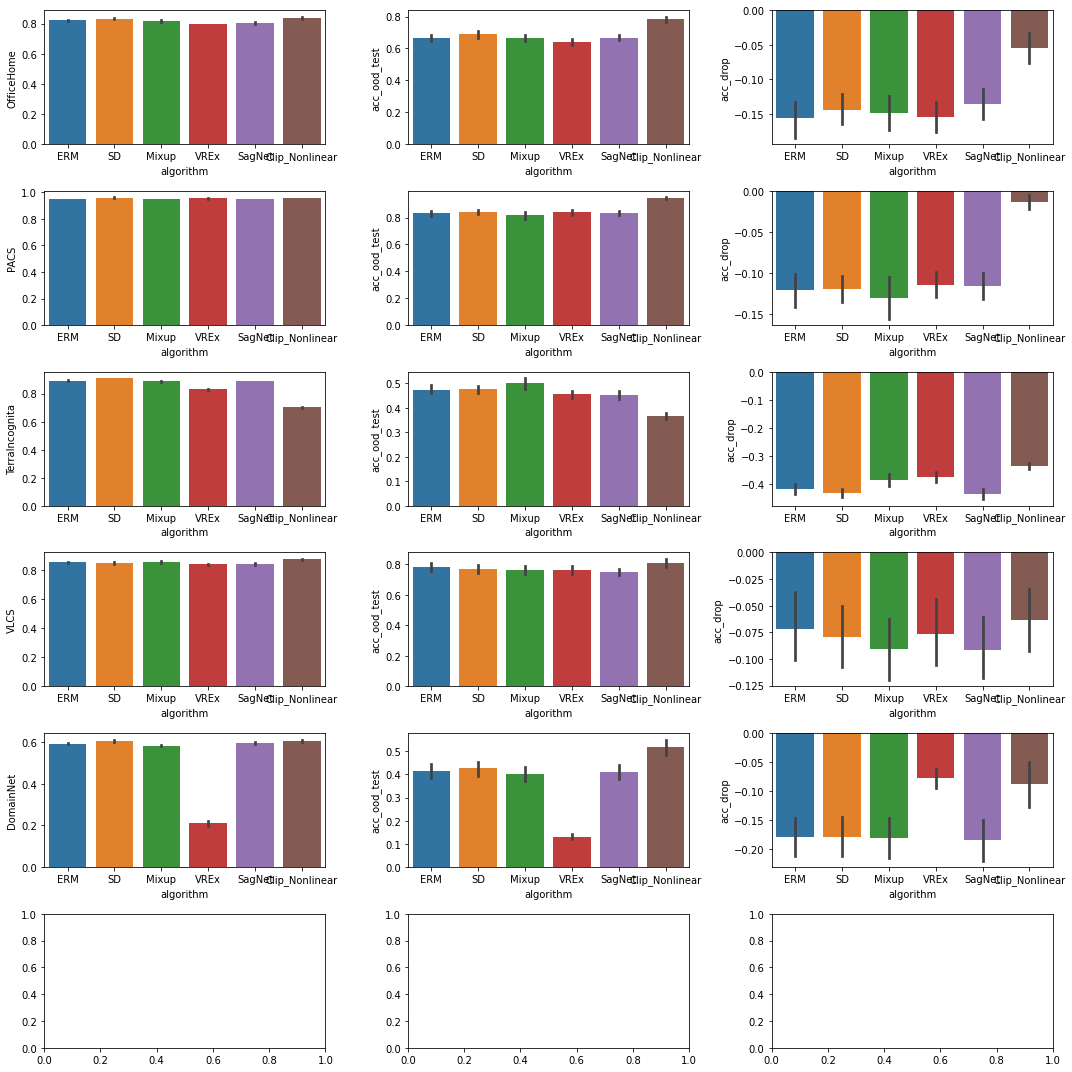

In [5]:
fig, ax = plt.subplots(len(algorithms), 3,
    figsize =(15, 15),
    tight_layout = True)

for e, dataset in enumerate(datasets):
    df_sub = df[df['dataset']== dataset]
    sns.barplot(data=df_sub, y='acc_iid_val', x='algorithm', ax=ax[e,0])
    sns.barplot(data=df_sub, y='acc_ood_test', x='algorithm', ax=ax[e,1])
    sns.barplot(data=df_sub, y='acc_drop', x='algorithm', ax=ax[e,2])

    ax[e,0].set_ylabel(dataset)
#sns.barplot(data=df, y='acc_ood_test', x='algorithm', ax=ax[1,0])
#sns.barplot(data=df, y='acc_ood_test', x='dataset', ax=ax[1,1])

# AUSC ALPHA

Text(0.5, 1.0, 'AUSC Alpha')

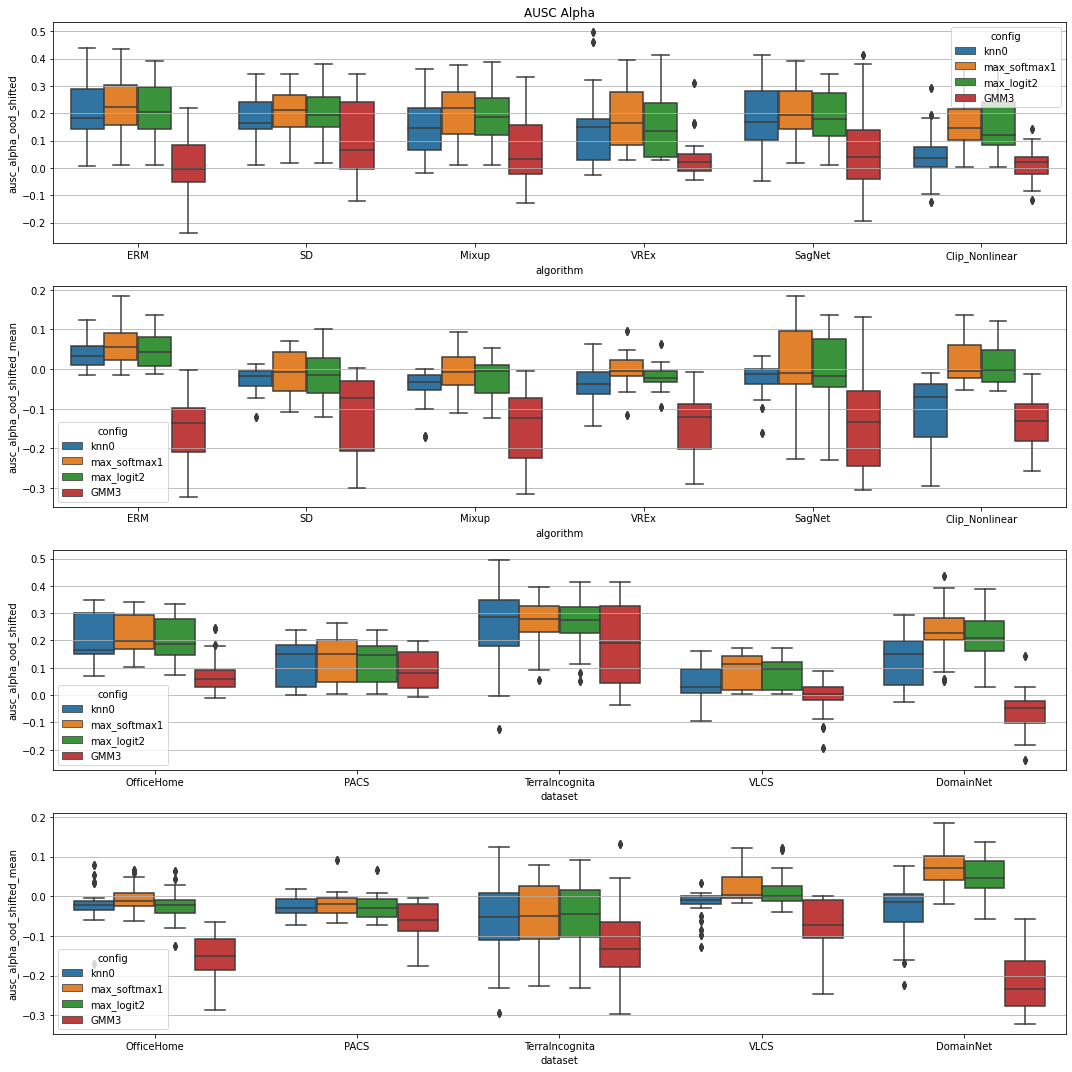

In [6]:
fig, ax = plt.subplots(4, 1,
    figsize =(15, 15),
    tight_layout = True)

df = pd.DataFrame(data=d)


sns.boxplot(data=df, x="algorithm", y="ausc_alpha_ood_shifted", hue='config', ax=ax[0])
ax[0].grid(axis='y')

sns.boxplot(data=df, x="algorithm", y="ausc_alpha_ood_shifted_mean", hue='config', ax=ax[1])
ax[1].grid(axis='y')

sns.boxplot(data=df, x="dataset", y="ausc_alpha_ood_shifted", hue='config', ax=ax[2])
ax[2].grid(axis='y')

sns.boxplot(data=df, x="dataset", y="ausc_alpha_ood_shifted_mean", hue='config', ax=ax[3])
ax[3].grid(axis='y')

ax[0].set_title("AUSC Alpha")

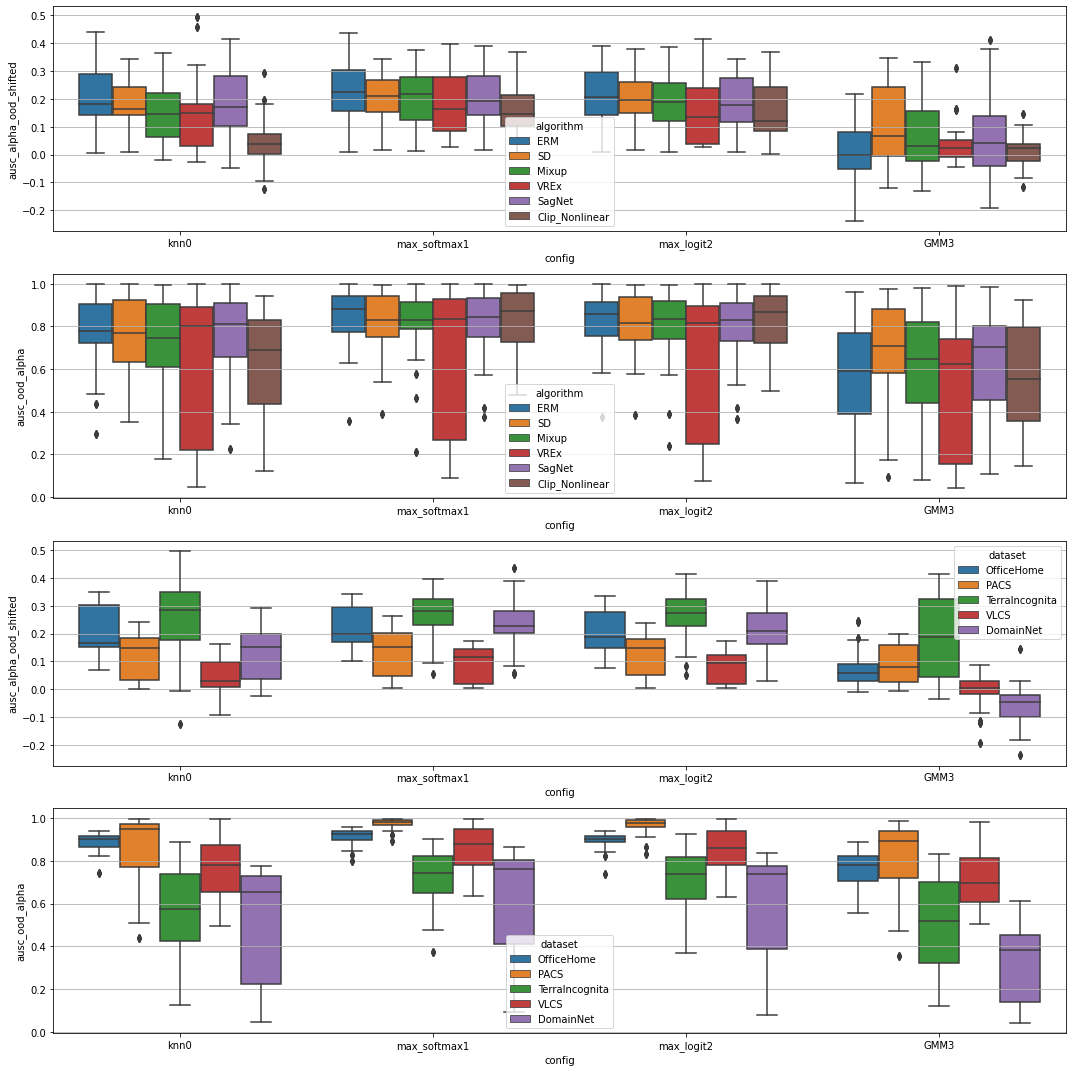

In [7]:
fig, ax = plt.subplots(4, 1,
    figsize =(15, 15),
    tight_layout = True)


sns.boxplot(data=df, x="config", y="ausc_alpha_ood_shifted", hue='algorithm', ax=ax[0])
ax[0].grid(axis='y')

sns.boxplot(data=df, x="config", y="ausc_alpha_ood_shifted", hue='dataset', ax=ax[2])
ax[1].grid(axis='y')

sns.boxplot(data=df, x="config", y="ausc_ood_alpha", hue='algorithm', ax=ax[1])
ax[2].grid(axis='y')

sns.boxplot(data=df, x="config", y="ausc_ood_alpha", hue='dataset', ax=ax[3])
ax[3].grid(axis='y')



## AUSC Fracs

Text(0.5, 1.0, 'AUSC Alpha')

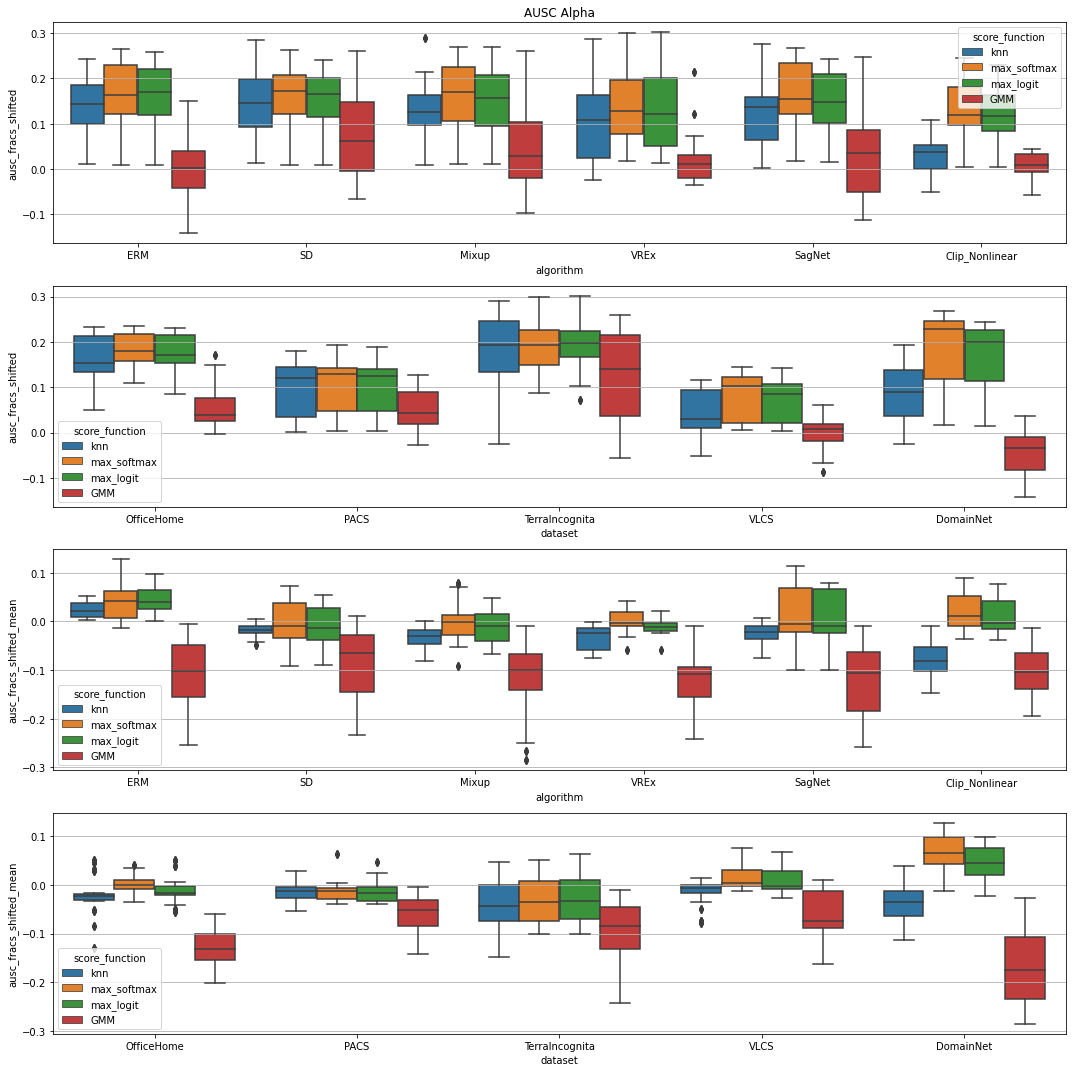

In [8]:
fig, ax = plt.subplots(4, 1,
    figsize =(15, 15),
    tight_layout = True)

df = pd.DataFrame(data=d)


sns.boxplot(data=df, x="algorithm", y="ausc_fracs_shifted", hue='score_function', ax=ax[0])
ax[0].grid(axis='y')

sns.boxplot(data=df, x="algorithm", y="ausc_fracs_shifted_mean", hue='score_function', ax=ax[2])
ax[1].grid(axis='y')

sns.boxplot(data=df, x="dataset", y="ausc_fracs_shifted", hue='score_function', ax=ax[1])
ax[2].grid(axis='y')

sns.boxplot(data=df, x="dataset", y="ausc_fracs_shifted_mean", hue='score_function', ax=ax[3])
ax[3].grid(axis='y')

ax[0].set_title("AUSC Alpha")

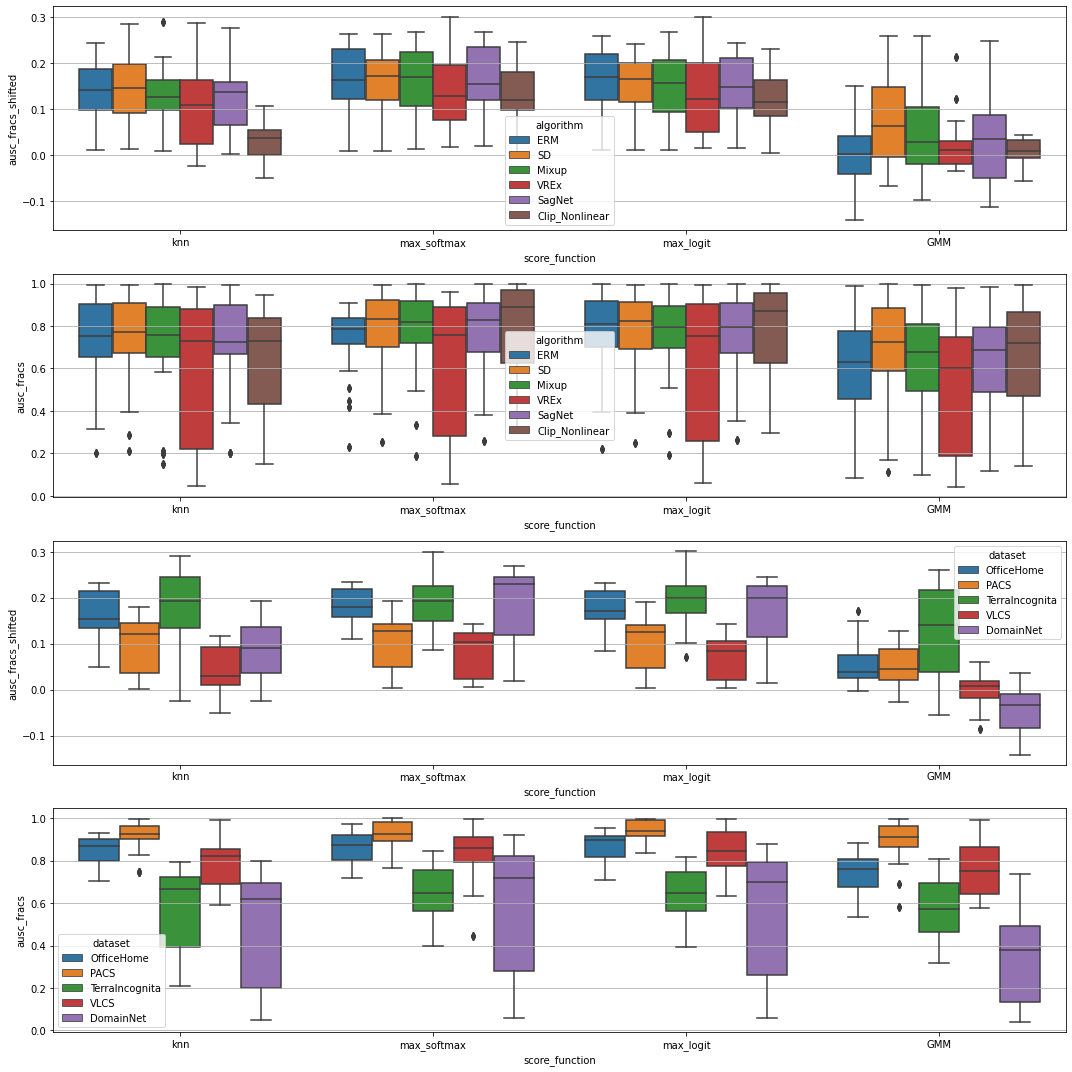

In [9]:
fig, ax = plt.subplots(4, 1,
    figsize =(15, 15),
    tight_layout = True)


sns.boxplot(data=df, x="score_function", y="ausc_fracs_shifted", hue='algorithm', ax=ax[0])
ax[0].grid(axis='y')

sns.boxplot(data=df, x="score_function", y="ausc_fracs_shifted", hue='dataset', ax=ax[2])
ax[1].grid(axis='y')

sns.boxplot(data=df, x="score_function", y="ausc_fracs", hue='algorithm', ax=ax[1])
ax[2].grid(axis='y')

sns.boxplot(data=df, x="score_function", y="ausc_fracs", hue='dataset', ax=ax[3])
ax[3].grid(axis='y')

# AUSC ECE Alpha and Fracs

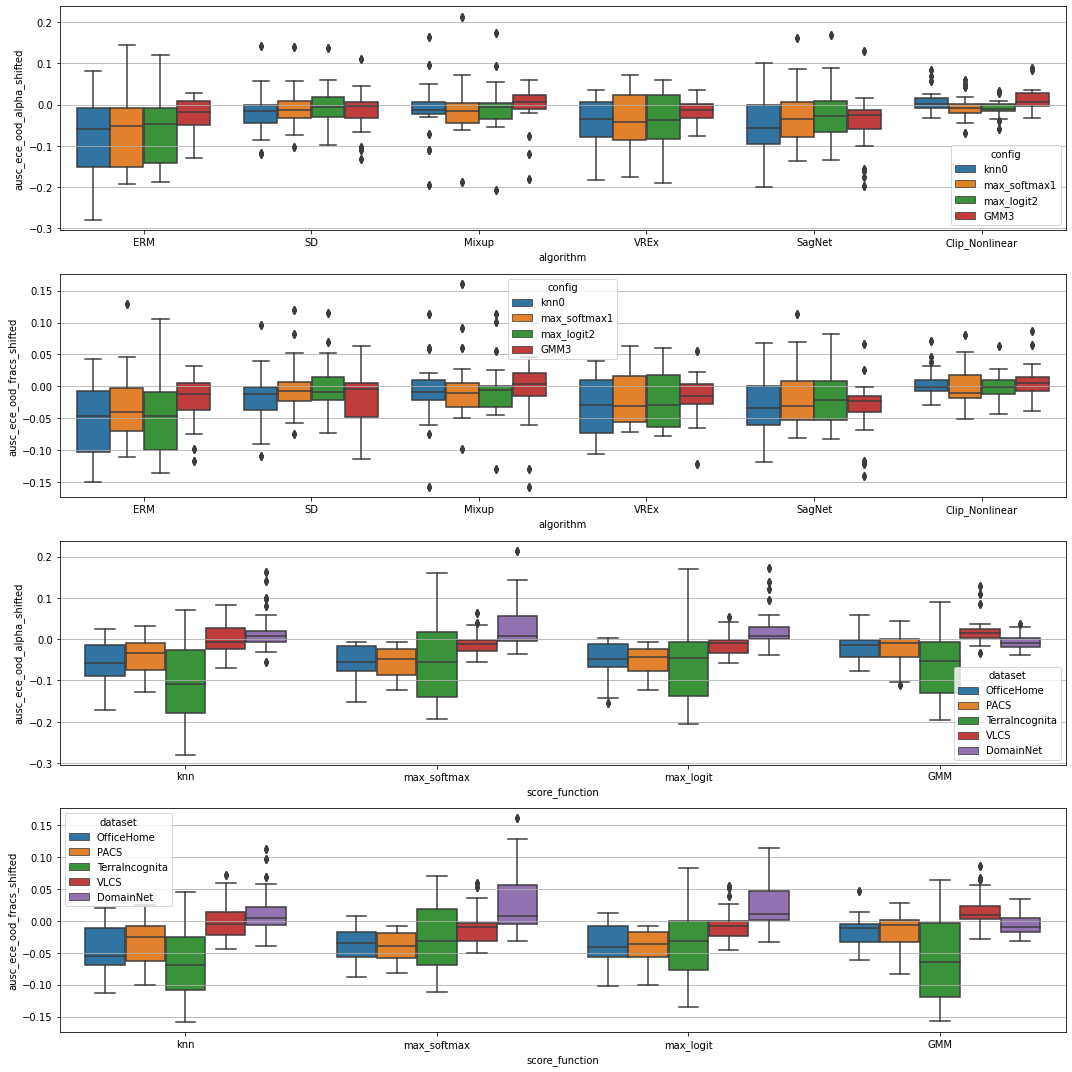

In [13]:
fig, ax = plt.subplots(4, 1,
    figsize =(15, 15),
    tight_layout = True)


sns.boxplot(data=df, x="algorithm", y="ausc_ece_ood_alpha_shifted", hue='config', ax=ax[0])
ax[0].grid(axis='y')

sns.boxplot(data=df, x="algorithm", y="ausc_ece_ood_fracs_shifted", hue='config', ax=ax[1])

sns.boxplot(data=df, x="score_function", y="ausc_ece_ood_alpha_shifted", hue='dataset', ax=ax[2])
ax[1].grid(axis='y')

ax[2].grid(axis='y')

sns.boxplot(data=df, x="score_function", y="ausc_ece_ood_fracs_shifted", hue='dataset', ax=ax[3])
ax[3].grid(axis='y')

# AUSC ECE Fracs

# IId Features

<AxesSubplot: xlabel='config', ylabel='ausc_alpha_ood_shifted'>

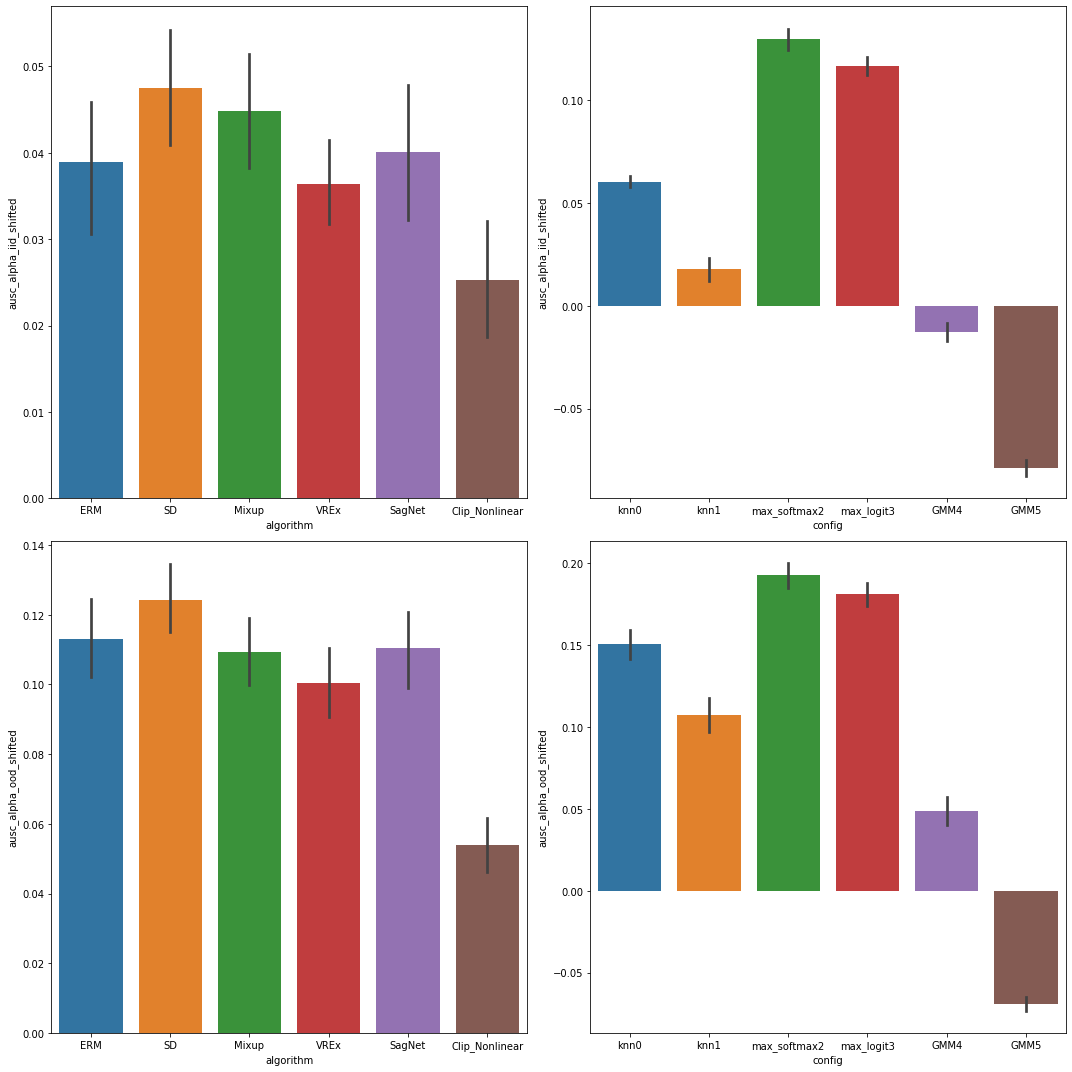

In [13]:
fig, ax = plt.subplots(2, 2,
    figsize =(15, 15),
    tight_layout = True)

sns.barplot(data=df, y='ausc_alpha_iid_shifted', x='algorithm', ax=ax[0,0])
sns.barplot(data=df, y='ausc_alpha_iid_shifted', x='config', ax=ax[0,1])

sns.barplot(data=df, y='ausc_alpha_ood_shifted', x='algorithm', ax=ax[1,0])
sns.barplot(data=df, y='ausc_alpha_ood_shifted', x='config', ax=ax[1,1])

ValueError: Could not interpret input 'ausc_alpha_iid'

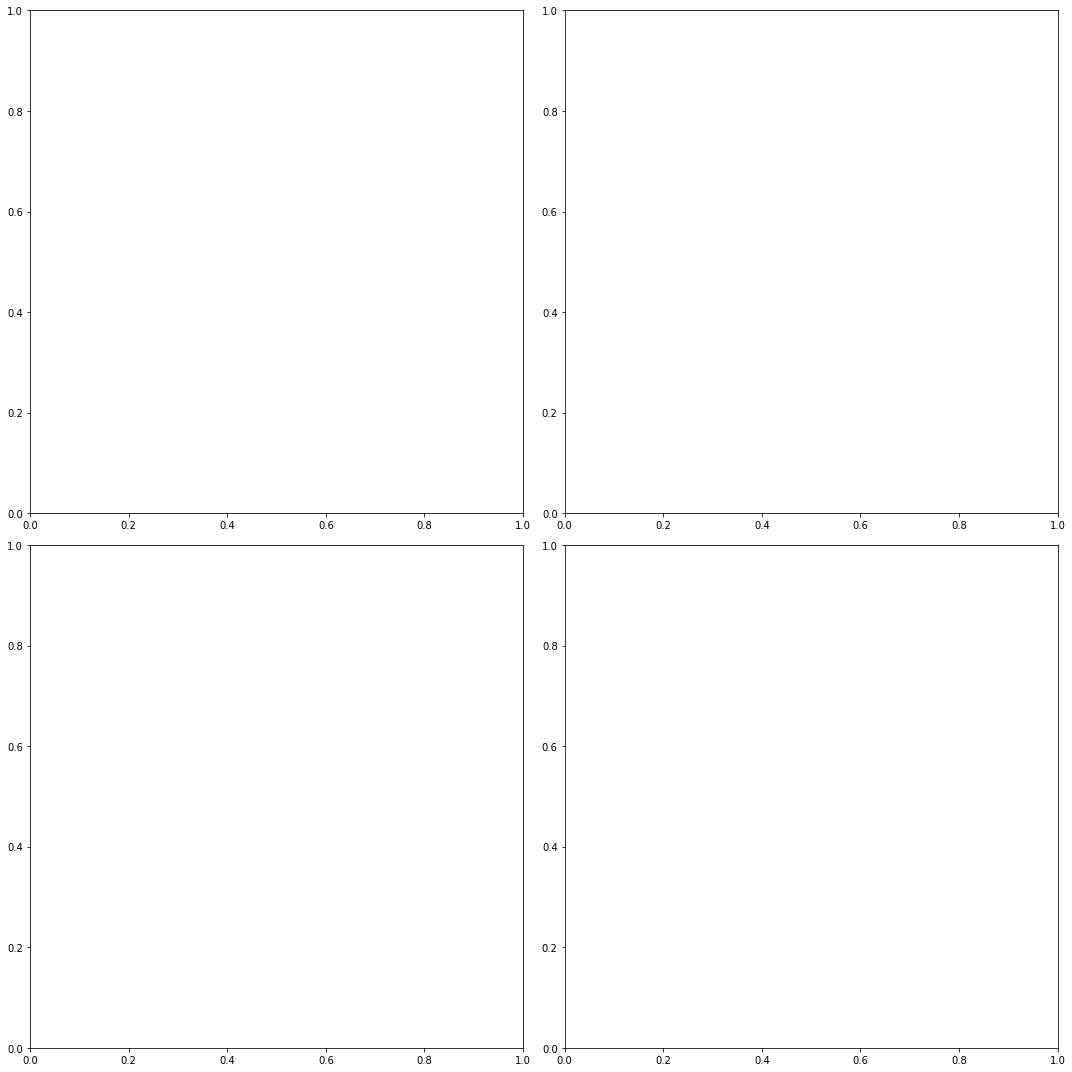

In [87]:
fig, ax = plt.subplots(2, 2,
    figsize =(15, 15),
    tight_layout = True)

sns.barplot(data=df, y='ausc_alpha_iid', x='algorithm', ax=ax[0,0])
sns.barplot(data=df, y='ausc_alpha_iid', x='config', ax=ax[0,1])

sns.barplot(data=df, y='ausc_alpha_ood', x='algorithm', ax=ax[1,0])
sns.barplot(data=df, y='ausc_alpha_ood', x='config', ax=ax[1,1])

In [ ]:
## Which iid feature is  predictive for acc

In [ ]:
fig, ax = plt.subplots(2, 2,
    figsize =(15, 10),
    tight_layout = True)

#df= df[df['config']=='knn0']

sns.scatterplot(x="ausc_alpha_iid_shifted", y="ausc_alpha_ood_shifted",data=df,  ax=ax[0,0], hue='algorithm')
ax[0,0].grid()
sns.scatterplot(x="acc_iid_val", y="ausc_alpha_ood_shifted",data=df,  ax=ax[0,1], hue='algorithm')
ax[0,1].grid()


sns.scatterplot(x="acc_drop", y="ausc_alpha_ood_shifted",data=df,  ax=ax[1,0], hue='algorithm')
ax[1,0].grid()
sns.scatterplot(x="acc_drop", y="ausc_fracs_shifted",data=df,  ax=ax[1,1], hue='dataset')
ax[1,1].grid()



In [ ]:
fig, ax = plt.subplots(2, 2,
    figsize =(15, 10),
    tight_layout = True)

#df= df[df['config']=='knn0']

sns.scatterplot(x="ece_iid_test", y="ausc_alpha_ood_shifted",data=df,  ax=ax[0,0], hue='algorithm')
ax[0,0].grid()
sns.scatterplot(x="ece_iid_test", y="ausc_alpha_ood_shifted",data=df,  ax=ax[0,1], hue='algorithm')
ax[0,1].grid()


sns.scatterplot(x="ece_iid_test", y="ausc_ece_ood_alpha_shifted",data=df,  ax=ax[1,0], hue='algorithm')
ax[1,0].grid()
sns.scatterplot(x="ece_iid_test", y="ausc_ece_ood_alpha_shifted",data=df,  ax=ax[1,1], hue='dataset')
ax[1,1].grid()



In [ ]:
sns.scatterplot(x="acc_iid_val", y="acc_ood_test",data=df, hue='dataset')
plt.plot([0.3,1], [0.3,1])